In [49]:
import trax
import trax.models

In [85]:
model = trax.models.Transformer(
    input_vocab_size=33300,
    d_model=512, d_ff=2048,
    n_heads=8, n_encoder_layers=6, n_decoder_layers=6,
    max_len=2048, mode='predict')

# Initialize using pre-trained weights.
model.init_from_file('../outputs/ende_wmt32k.pkl.gz',
                     weights_only=True)

sentence = 'It is nice to learn new things today!'
tokenized = list(trax.data.tokenize(iter([sentence]),  # Operates on streams.
                                    vocab_dir='../outputs/',
                                    vocab_file='ende_32k.subword'))[0]

tokenized = tokenized[None, :]  # Add batch dimension.

tokenized_translation = trax.supervised.decoding.autoregressive_sample(
    model, tokenized, temperature=0.0)  # Higher temperature: more diverse results.

tokenized_translation = tokenized_translation[0][:-1]  # Remove batch and EOS.

translation = trax.data.detokenize(tokenized_translation, vocab_dir='../outputs/', vocab_file='ende_32k.subword')
print(translation)


Es ist schön, heute neue Dinge zu lernen!


In [53]:
print(model)

Serial_in2_out2[
  Select[0,1,1]_in2_out3
  Branch_out2[
    []
    Serial[
      PaddingMask(0)
    ]
  ]
  Cache_in2_out2[
    Serial_in2_out2[
      Embedding_33300_512
      Dropout
      PositionalEncoding
      Serial_in2_out2[
        Branch_in2_out3[
          None
          Serial_in2_out2[
            LayerNorm
            Serial_in2_out2[
              _in2_out2
              Serial_in2_out2[
                Select[0,0,0]_out3
                Serial_in4_out2[
                  _in4_out4
                  Serial_in4_out2[
                    Parallel_in3_out3[
                      Dense_512
                      Dense_512
                      Dense_512
                    ]
                    PureAttention_in4_out2
                    Dense_512
                  ]
                  _in2_out2
                ]
              ]
              _in2_out2
            ]
            Dropout
          ]
        ]
        Add_in2
      ]
      Serial[
        Branch_out2[
          N

In [60]:
import tensorflow as tf
import trax

# Assuming 'model' is your Trax model
keras_layer = trax.AsKeras(model, batch_size=1)

# Define two inputs: one for `input_ids` and another for `target_ids`
input_ids = tf.keras.Input(shape=(1024,), dtype='int32', name="input_ids")
target_ids = tf.keras.Input(shape=(1024,), dtype='int32', name="target_ids")

# Pass both inputs to the keras_layer (tuple of inputs)
hidden = keras_layer((input_ids, target_ids))

# Define the Keras model with two inputs and one output
outputs = hidden
keras_model = tf.keras.Model(inputs=[input_ids, target_ids], outputs=outputs)

# Build the model
keras_model.build(input_shape=[(None, 1024), (None, 1024)])
keras_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_ids          │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ as_keras_13         │ [(1, 1024,        │          0 │ input_ids[0][0],  │
│ (AsKeras)           │ 33300), (1,       │            │ target_ids[0][0]  │
│                     │ 1024)]            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [74]:
import numpy as np

# Tokenize your sentence (this assumes you have a tokenizer with a vocab size matching your model's)
sentence = "It is nice to learn new things today!"
tokenized_input = list(trax.data.tokenize(iter([sentence]), vocab_dir='../google/', vocab_file='ende_32k.subword'))[0]

# Pad or truncate to 1024 tokens
tokenized_input = np.pad(tokenized_input, (0, 1024 - len(tokenized_input)), mode='constant')[:1024]
tokenized_input = np.array([tokenized_input], dtype='int32')  # Add batch dimension

# Set up the target input (empty or start tokens depending on your setup)
# Here, we'll use an example target that matches the structure of `tokenized_input`.
target_input = np.zeros((1, 1024), dtype='int32')

# Run through Keras model
output = keras_model([tokenized_input, target_input])
# predicted_token = tf.argmax(output[0], axis=-1)
# print(predicted_token)

print(output[1])


tf.Tensor([[0 0 0 ... 0 0 0]], shape=(1, 1024), dtype=int32)


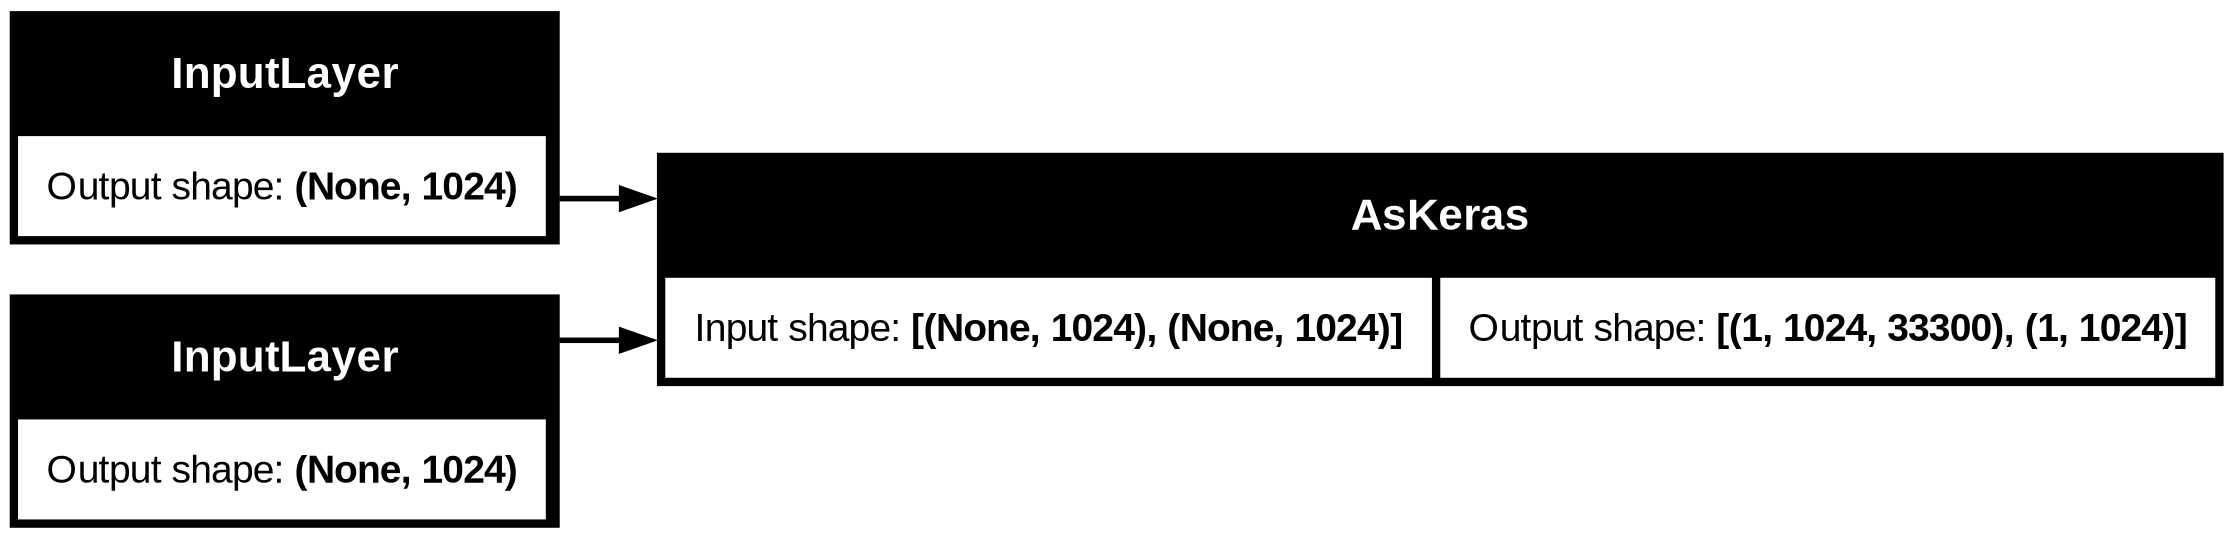

In [91]:
from tensorflow.keras.utils import plot_model

# Generate a plot of the model architecture
plot_model(keras_model, show_shapes=True, expand_nested=True, rankdir='LR', to_file='../outputs/model.png')

In [ ]:
# Save weights to a file
weights_file = '../outputs/ml_assignment_seq2seq.weights.h5'
keras_model.save_weights(weights_file)

In [63]:
def create_keras_model():
  model = trax.models.Transformer(
      input_vocab_size=33300,
      d_model=512, d_ff=2048,
      n_heads=8, n_encoder_layers=6, n_decoder_layers=6,
      max_len=2048, mode='predict')
  
  model.init_from_file('../outputs/ende_wmt32k.pkl.gz', weights_only=True)
  sample = "Hello"
  tokenized = preprocess_text(sample)
  tokenized_translation = trax.supervised.decoding.autoregressive_sample(
      model, tokenized, temperature=0.0)
  translation = postprocess_output(tokenized_translation)

  keras_layer = trax.AsKeras(model, batch_size=1)
  input_ids = tf.keras.Input(shape=(1024,), dtype='int32', name="input_ids")
  target_ids = tf.keras.Input(shape=(1024,), dtype='int32', name="target_ids")

  hidden = keras_layer((input_ids, target_ids))
  outputs = hidden
  keras_model = tf.keras.Model(inputs=[input_ids, target_ids], outputs=outputs)

  return keras_model


keras_model = create_keras_model()
